In [4]:
def get_reward(user, item, context):

    time_of_day = context['time_of_day']

    USER_LIKED_ARTICLE = 1
    USER_DISLIKED_ARTICLE = 0

    if user == 'Tom':
        if time_of_day == 'morning' and item == 'politics':
            return USER_LIKED_ARTICLE
        elif time_of_day == 'afternoon' and item == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif user == 'Anna':
        if time_of_day == 'morning' and item == 'sports':
            return USER_LIKED_ARTICLE
        elif time_of_day == 'afternoon' and item == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

get_reward('Tom', 'politics', {'time_of_day': 'morning'})

1

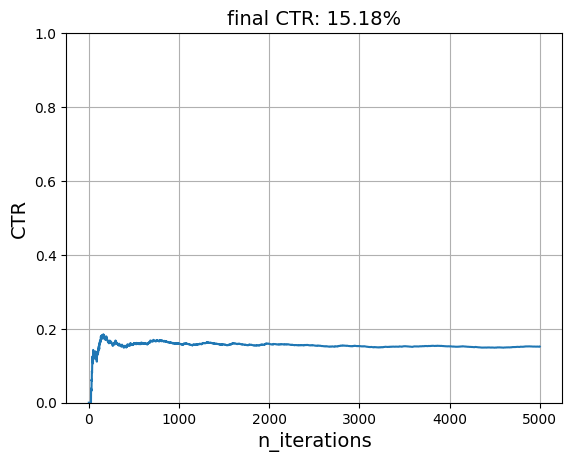

In [5]:
import random
import matplotlib.pyplot as plt

def plot_ctr(ctr):
    plt.plot(range(1, len(ctr) + 1), ctr)
    plt.xlabel('n_iterations', fontsize=14)
    plt.ylabel('CTR', fontsize=14)
    plt.ylim([0, 1])
    plt.title(f'final CTR: {ctr[-1]:.2%}', fontsize=14)
    plt.grid()

users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
items = {'politics', 'sports', 'music', 'food', 'finance', 'health', 'camping'}

def simulate(n, reward_func, model, seed):

    rng = random.Random(seed)
    n_clicks = 0
    ctr = []  # click-through rate along time

    for i in range(n):

        # Generate a context at random
        user = rng.choice(users)
        context = {
            'time_of_day': rng.choice(times_of_day)
        }

        # Make a single recommendation
        item = model.rank(user, items=items, x=context)[0]

        # Measure the reward
        clicked = reward_func(user, item, context)
        n_clicks += clicked
        ctr.append(n_clicks / (i + 1))

        # Update the model
        model.learn_one(user, item, y=clicked, x=context)

    plot_ctr(ctr)
    
from river import reco

model = reco.RandomNormal(seed=10)
simulate(5_000, get_reward, model, seed=42)

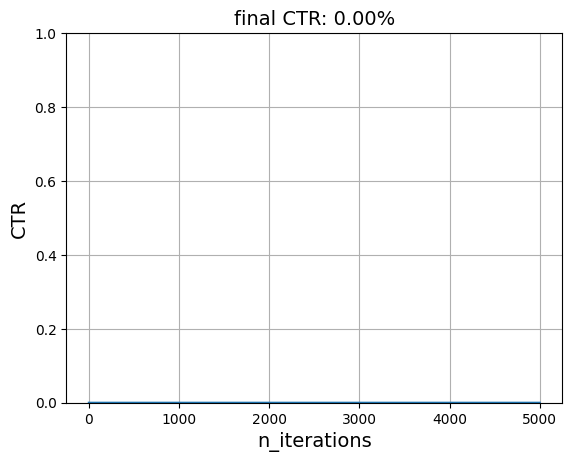

In [6]:
model = reco.Baseline(seed=10)
simulate(5_000, get_reward, model, seed=42)

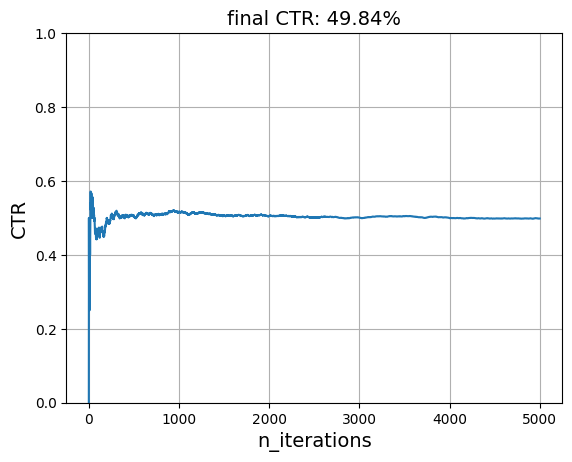

In [7]:
simulate(
    5_000,
    reward_func=lambda user, item, context: (
        item in {'music', 'politics'} if user == "Tom" else
        item in {'food', 'sports'}
    ),
    model=model,
    seed=42
)

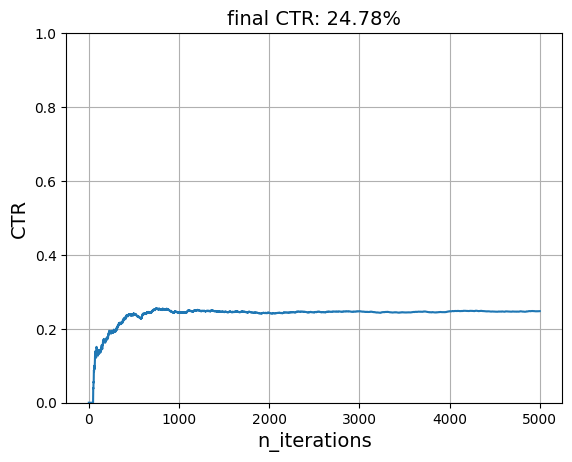

In [8]:
model = reco.FunkMF(seed=10)
simulate(5_000, get_reward, model, seed=42)

times_of_day = ['morning', 'afternoon']

def get_reward(user, item, context):
    if user == 'Tom':
        if context['time_of_day'] == 'morning':
            return item == 'politics'
        if context['time_of_day'] == 'afternoon':
            return item == 'music'
    if user == 'Anna':
        if context['time_of_day'] == 'morning':
            return item == 'sports'
        if context['time_of_day'] == 'afternoon':
            return item == 'politics'

In [9]:
def simulate(n, reward_func, model, seed):

    rng = random.Random(seed)
    n_clicks = 0
    ctr = []

    for i in range(n):

        user = rng.choice(users)

        # New: pass a context
        context = {'time_of_day': rng.choice(times_of_day)}
        item = model.rank(user, items, context)[0]

        clicked = reward_func(user, item, context)
        n_clicks += clicked
        ctr.append(n_clicks / (i + 1))

        # New: pass a context
        model.learn_one(user, item, clicked, context)

    plot_ctr(ctr)

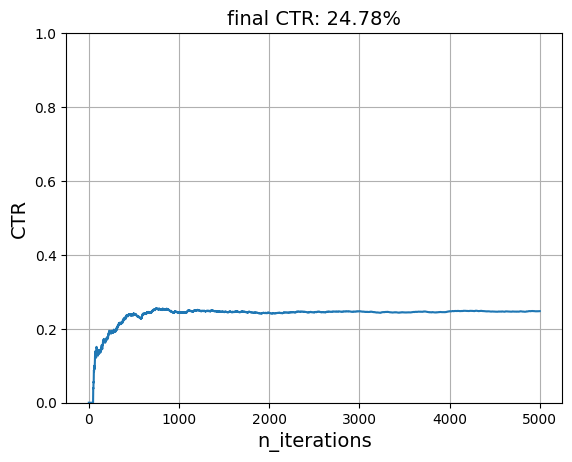

In [11]:
model = reco.FunkMF(seed=10)
model.is_contextual

simulate(5_000, get_reward, model, seed=42)

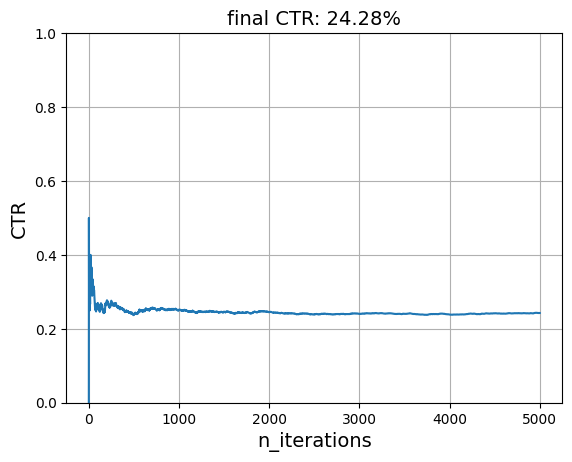

In [12]:
class FunkMFWithHack(reco.FunkMF):

    def learn_one(self, user, item, reward, context):
        user = f"{user}@{context['time_of_day']}"
        return super().learn_one(user, item, reward, context)

    def rank(self, user, items, context):
        user = f"{user}@{context['time_of_day']}"
        return super().rank(user, items, context)

model = FunkMFWithHack(seed=29)
simulate(5_000, get_reward, model, seed=42)


import pandas as pd

(
    pd.DataFrame(
        {
            'user': user,
            'item': item,
            'preference': model.predict_one(user, item)
        }
        for user in model.u_latents
        for item in model.i_latents
    )
    .pivot(index='user', columns='item')
    .style.highlight_max(color='lightgreen', axis='columns')
)